# Previsão de renda

## Etapa 1 CRISP - DM: Entendimento do negócio


**Objetivo do Negócio:** O objetivo é prever a renda salarial de um indivíduo com base em características como gênero, nível de educação, idade, entre outros, a fim de entender melhor os fatores que influenciam a renda e possivelmente melhorar a tomada de decisão em políticas públicas, recrutamento, entre outros.

**Critério de Sucesso:** O critério de sucesso pode ser definido pela precisão da previsão da renda salarial, medida por uma métrica como o erro médio absoluto ou o erro quadrático médio.

**Descrição do Produto:** O produto final seria um modelo de previsão de renda salarial baseado em dados, que pode ser usado para prever a renda com base nas características fornecidas.

## Etapa 2 Crisp-DM: Entendimento dos dados

### Dicionário de dados


| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  data_de registro                                      | data|
| id_cliente              |  id do cliente                                       | int|
| sexo                    |  gênero                                      | str|
| posse_de_veiculo        |  possui ou não veículo                                       | bool|
| posse_de_imovel         |  possui ou não imóvel                                       | bool|
| qtd_filhos              |  quantos filhos possui                                       | int|
| tipo_renda              |  qual categoria de emprego                                       | str|
| educacao                |  qual nível de educação                                       | str|
| estado_civil            |  qual estado civíl                                       | str|
| tipo_residencia         |  qual tipo de residência                                       | str|
| idade                   |  idade do cliente                                       | int|
| tempo_emprego           |  tempo em um emprego                                       | float|
| qt_pessoas_residencia   |  quantidade de pessoas na residência do cliente                                       | int|
| renda                   |  valor salarial                                       | float|





#### Carregando os pacotes

Instalando e carregando pacotes necessários para o projeto.


In [1]:
!pip install ydata-profiling

import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
from sklearn.neighbors import KNeighborsRegressor

sns.set_theme(style="darkgrid", palette = "pastel6")

#### Carregando os dados
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [2]:
renda = pd.read_csv('./input/previsao_de_renda.csv')

#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis.

In [3]:
prof = ProfileReport(renda, explorative=True, )
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
os.makedirs('./output', exist_ok = True)

In [5]:
prof.to_file('./output/renda_analisys.html')

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

> É possível notar colunas que não serão úteis no processo, como Unnamed: 0, id_cliente e data_ref. Há ainda colunas como qtd_filhos, estado_civil e tipo_residencia que, por conta de sua distribuição, podem não serem úteis ao nosso modelo.


### Entendimento dos dados - Bivariadas




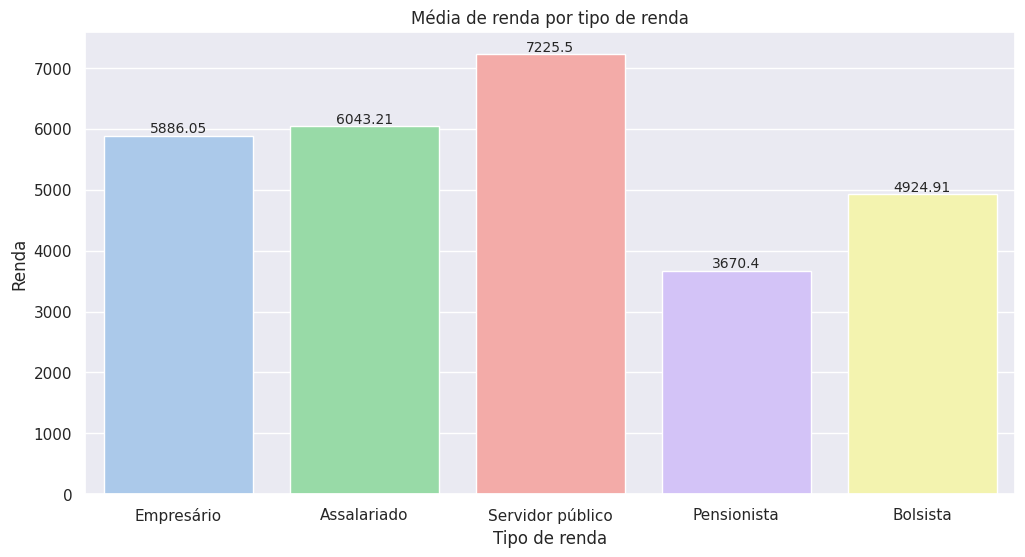

In [6]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(renda, x = "tipo_renda", y = "renda", errorbar = None)
ax.bar_label(ax.containers[0], fontsize=10)
ax.set(title = "Média de renda por tipo de renda", xlabel = "Tipo de renda", ylabel = "Renda");

> É possível notar semelhança na renda média de empresários e assalariados, já servidores públicos possuem maior média entre as categorias registradas.

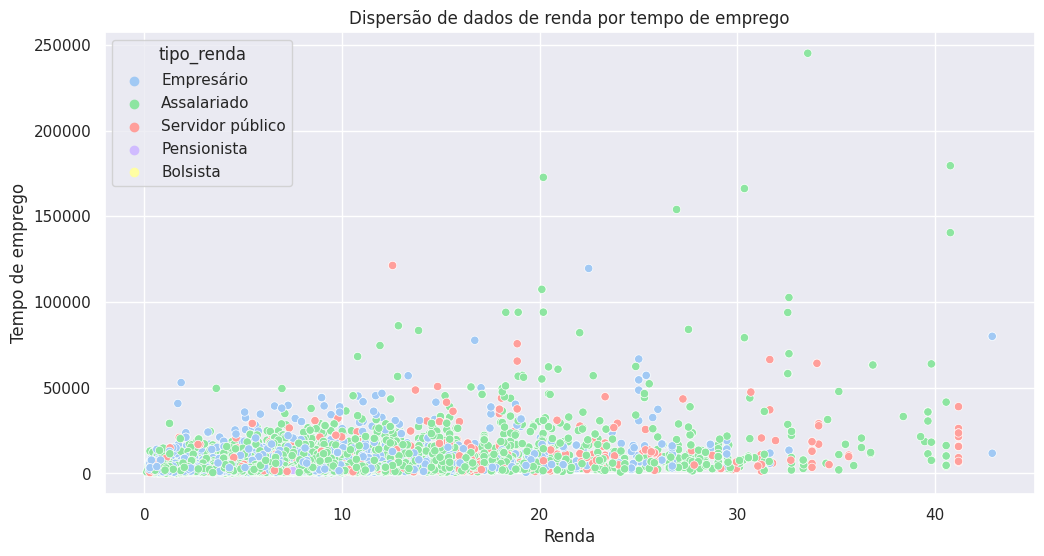

In [7]:
plt.figure(figsize = (12, 6))
ax = sns.scatterplot(renda, x = "tempo_emprego", y = "renda", hue = "tipo_renda")
ax.set(title = "Dispersão de dados de renda por tempo de emprego", xlabel = "Renda", ylabel = "Tempo de emprego");

> Empregados assalariados se destacam entre as rendas mais altas

<Figure size 1200x600 with 0 Axes>

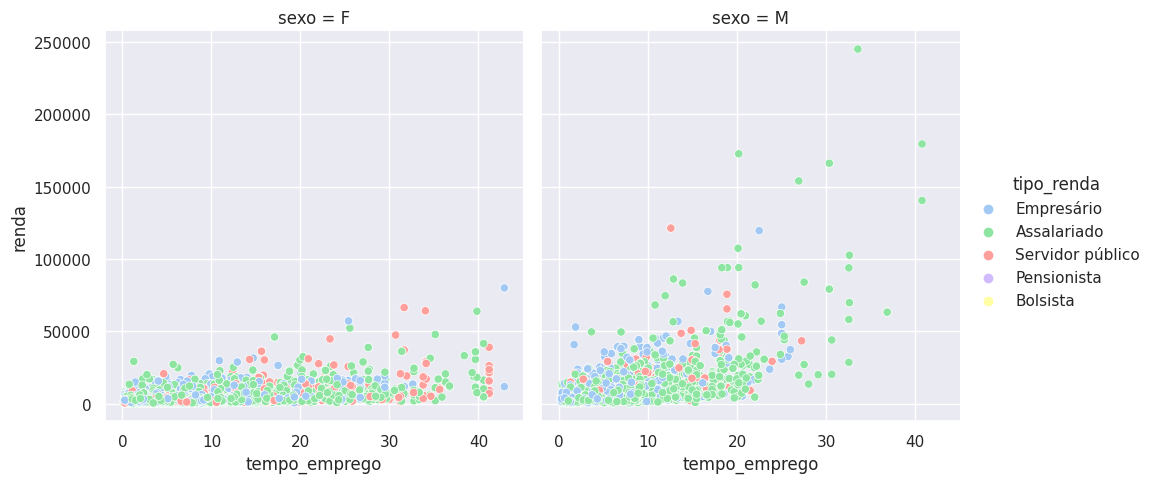

In [8]:
plt.figure(figsize = (12, 6))
ax = sns.relplot(renda, x = "tempo_emprego", y = "renda", hue = "tipo_renda", col = "sexo")

> Homens parecem ter maiores chances de evolução salarial com maior experiência

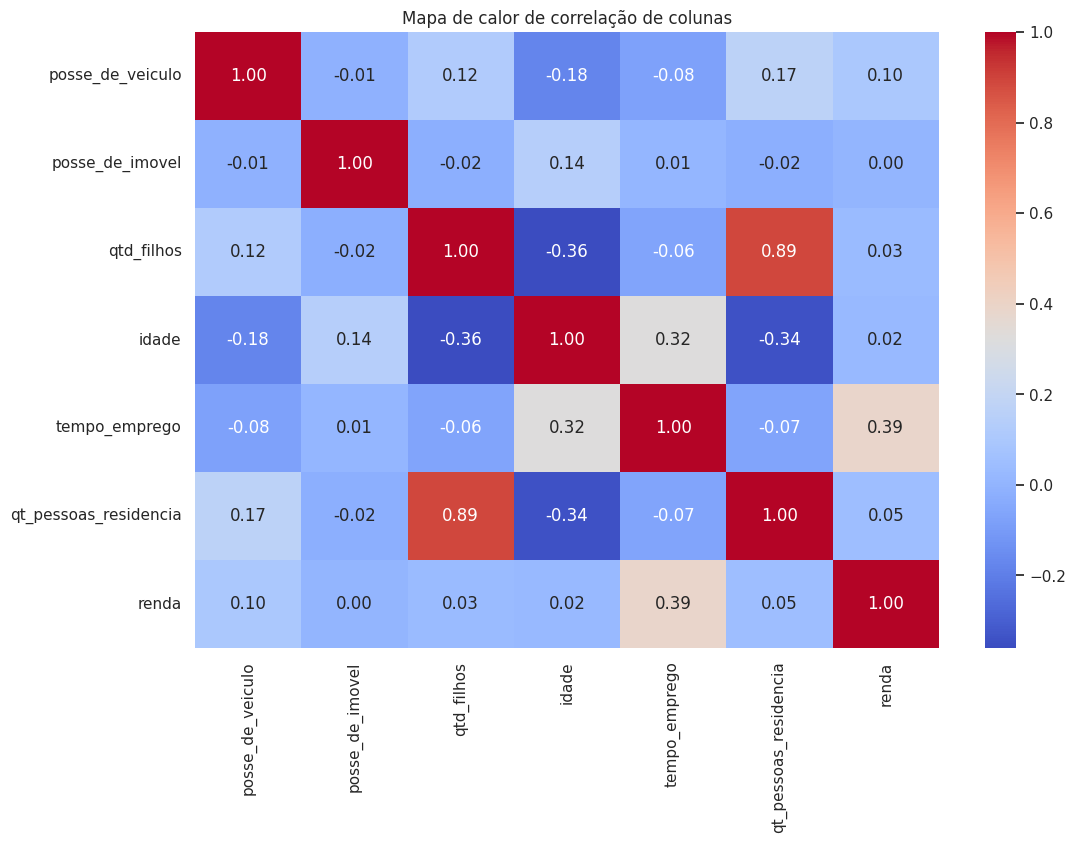

In [9]:
corr = renda.drop(['Unnamed: 0', 'id_cliente'], axis = 1).corr(numeric_only = True)

plt.figure(figsize =  (12, 8))
sns.heatmap(corr, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Mapa de calor de correlação de colunas")
plt.show();

> A coluna com maior correlação com a target(renda) é a tempo_emprego.

## Etapa 3 Crisp-DM: Preparação dos dados


In [10]:
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [11]:
renda_prep = renda.copy()

In [12]:
# Removendo colunas avaliadas como não úteis

renda_prep.drop(['Unnamed: 0', 'id_cliente', 'data_ref'], axis = 1, inplace = True)

In [13]:
# Número de linhas com valores nulos na coluna tempo_emprego

renda_prep.tempo_emprego.isna().sum()

2573

In [14]:
# Visto que a coluna tempo_emprego tem grande correlação com a target renda,
# irei remover as linhas com valores nulo

renda_prep.dropna(subset = 'tempo_emprego', inplace = True)

In [15]:
# Verificando distribuição de dados na coluna tipo_residencia

renda_prep['tipo_residencia'].value_counts(normalize=True)

Casa             0.890883
Com os pais      0.054237
Governamental    0.028969
Aluguel          0.014726
Estúdio          0.006035
Comunitário      0.005150
Name: tipo_residencia, dtype: float64

In [16]:
# Dado o alto desbalanceamento na distribuição de dados na coluna
# tipo_residencia, irei removê-la do dataframe

renda_prep.drop('tipo_residencia', axis = 1, inplace = True)

In [17]:
# Verificando dados da coluna qt_pessoas_residencia que possui dtype float64

renda_prep['qt_pessoas_residencia'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  9., 15.,  7.])

In [18]:
# Convertendo coluna para int

renda_prep['qt_pessoas_residencia'] = renda_prep['qt_pessoas_residencia'].astype('int')

In [19]:
renda_prep.shape

(12427, 11)

## Etapa 4 Crisp-DM: Modelagem



Utilizando modelo Lasso(L2) de regularização para efetuar seleção de variáveis do modelo de regressão, e statsmodel OLS para predição.


### Rodando o modelo


In [20]:
# Selecionando colunas que usaremos

renda_model = renda_prep[['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'qt_pessoas_residencia','idade', 'tempo_emprego', 'renda']]

In [21]:
# Aplicando OHE nas colunas categóricas

columns_to_encode = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao']
dummies = pd.get_dummies(renda_model[columns_to_encode])
df_encoded = pd.concat([renda_model, dummies], axis=1)
df_encoded.drop(columns_to_encode, axis=1, inplace=True)

In [22]:
# Separando dados em features e target

X,y = df_encoded.drop('renda', axis = 1), df_encoded['renda']

In [23]:
# Separando dados em dados de treino e de teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2024)

In [24]:
# Criando modelo KNN

KNN_model = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)

### Avaliação do modelo

In [25]:
# Calculando precisão do modelo

y_pred = KNN_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: \t{mse}\t")
r2 = r2_score(y_test, y_pred)
print("R²:\t", r2)

MSE: 	44453104.15825728	
R²:	 0.3804841847685534


## Etapa 5 Crisp-DM: Avaliação dos resultados


Algumas métricas do modelo:


*   MSE: 	44453104.15825728
*   R²:	 0.3804841847685534





In [26]:
# Criando dataframe unindo predição e valor real
resultados = pd.DataFrame(y_pred, columns = ["y_pred"])

resultados["y_true"] = y_test.values

resultados.set_index(y_test.index, inplace = True)

In [27]:
# Adicionando coluna com diferença do valor real para a predição

resultados = resultados.assign(diferenca = lambda x: x['y_true'] - x['y_pred'])

In [28]:
resultados

y_pred    y_true    diferenca
10555   5089.103333   4349.39  -739.713333
11848   2746.726667   4088.92  1342.193333
10841   4012.190000   8060.25  4048.060000
10384   3855.940000   1178.15 -2677.790000
412     7624.500000   7624.50     0.000000
...             ...       ...          ...
8403    4702.580000   2327.48 -2375.100000
1607    4868.196667   1904.33 -2963.866667
7393   14897.740000  11774.90 -3122.840000
6235    2907.176667   3422.97   515.793333
9611    6765.956667   1772.62 -4993.336667

[3107 rows x 3 columns]

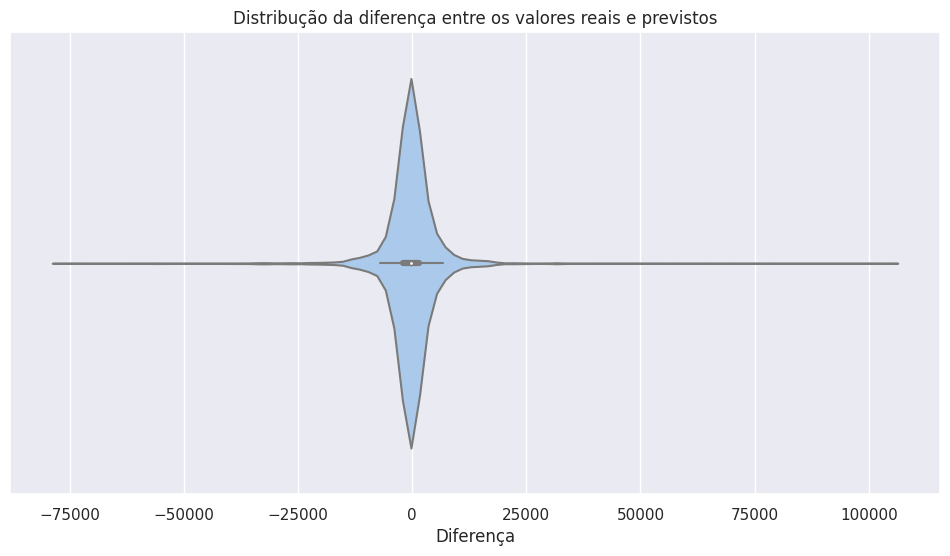

In [30]:
# Plotando gráfico de violino para demonstrar distribuição da diferença entre os valores reais e a previsão

plt.figure(figsize = (12, 6))
sns.violinplot(resultados, x = "diferenca")
plt.xlabel("Diferença")
plt.title("Distribução da diferença entre os valores reais e previstos")
plt.show()

In [31]:
# Calculando RMSE para visualizar erro médio em unidades iguais as da target original (reais)

rmse = np.sqrt(mean_squared_error(resultados['y_true'], resultados['y_pred']))

rmse

6667.316113569033

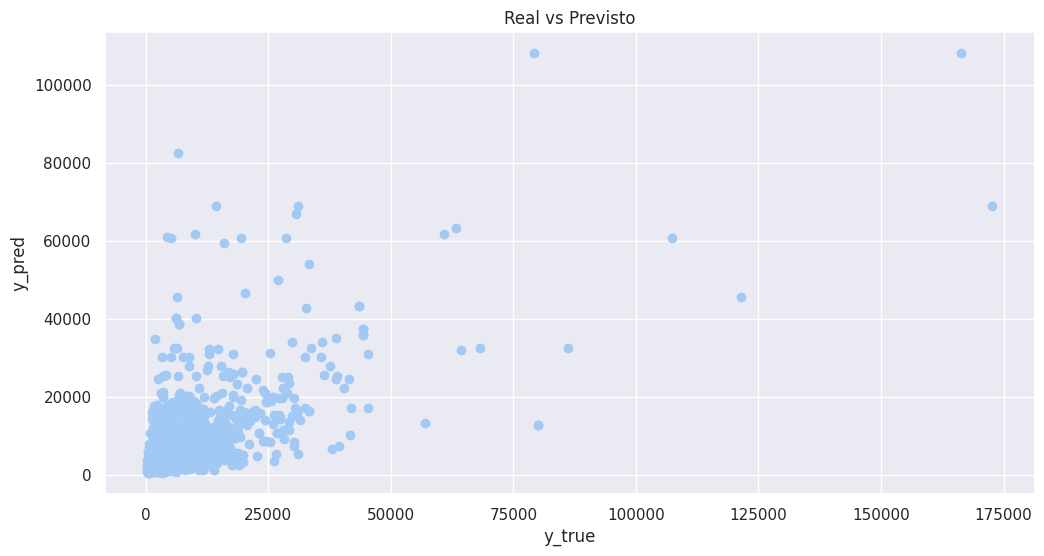

In [32]:
# Visualizando dados previstos vs reais em um scatterplot

plt.figure(figsize = (12, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Real vs Previsto')
plt.show()

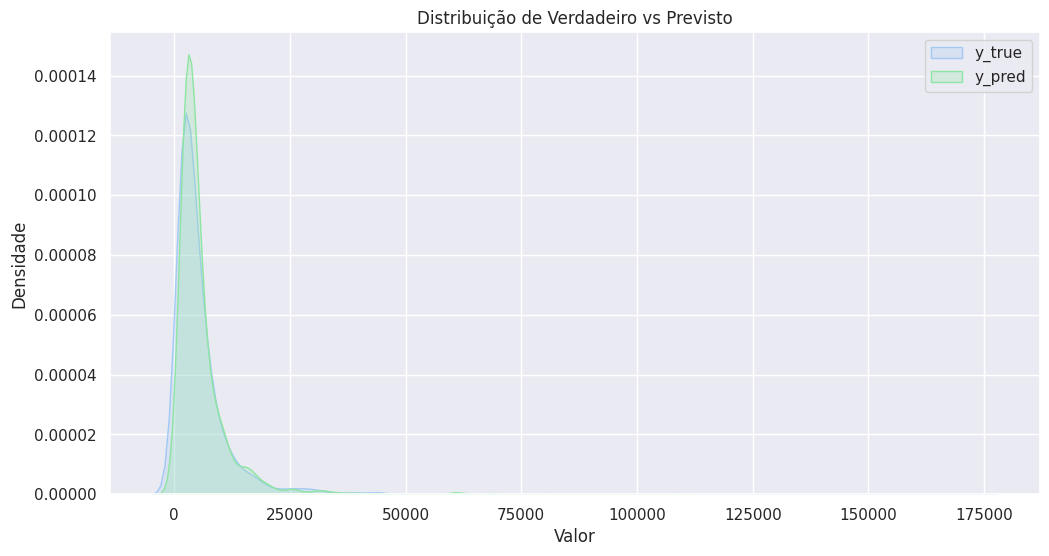

In [33]:
# Plotando gráfico com distribuição suavizada de valores reais vs preditos

plt.figure(figsize = (12, 6))
sns.kdeplot(y_test, label='y_true', fill=True)
sns.kdeplot(y_pred, label='y_pred', fill=True)
plt.xlabel('Valor')
plt.ylabel('Densidade')
plt.title('Distribuição de Verdadeiro vs Previsto')
plt.legend()
plt.show()

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.